# Investigate a stock to understand what the target "looks like"

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
#from pprint import pprint
import numpy as np

import random
#import memory_profiler
#import altair as alt
#from tqdm import tqdm
import datetime

#import ipython_memory_usage
#%ipython_memory_usage_start


In [18]:
from utility import ROOT, TEST_CSV, TRAIN_CSV
df_train_all = pd.read_csv(TRAIN_CSV)
df_train_all = df_train_all.set_index(['stock_id', 'time_id'])

In [19]:
df_train_all.shape

(428932, 1)

In [20]:
df_train_all.sample(100)

,,target
stock_id,time_id,
118,8913,0.009657
105,11062,0.008116
35,17695,0.002312
103,3069,0.006710
53,1712,0.001630
...,...,...
10,7518,0.005520
18,7837,0.011506
17,28992,0.004542


In [21]:
def show_details(df):
    try:
        nbr_index_levels = len(df.index.levels)
    except AttributeError:
        nbr_index_levels = 1
    nbr_nulls = df.isnull().sum().sum()
    #nulls_msg = "Has no nulls"
    #if nbr_nulls==0:
    nulls_msg = f"{nbr_nulls} nulls"
    is_view_msg = f'is_view {df_train_all._data.is_view}'
    is_single_block_msg = f'is_single_block {df_train_all._data.is_single_block}'
    is_consolidated_msg = f'is_consolidated {df_train_all._data.is_consolidated()}'   
    is_mixed_numeric = f'numeric mixed {df._data.is_numeric_mixed_type}'
    print(f'[{nbr_index_levels}c] {df.shape[0]:,}x{df.shape[1]:,}, {nulls_msg}, {is_view_msg}, {is_single_block_msg}, {is_consolidated_msg}, {is_mixed_numeric}')

    

def set_common_mpl_styles(
    ax, legend=True, grid_axis="y", ylabel=None, xlabel=None, title=None, ymin=None, xmin=None
):
    ax.grid(axis=grid_axis)
    if legend == False:
        ax.legend_.remove()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if title is not None:
        ax.set_title(title)
    if ymin is not None:
        ax.set_ylim(ymin=ymin)
    if xmin is not None:
        ax.set_xlim(xmin=xmin)
    
show_details(df_train_all)

[2c] 428,932x1, 0 nulls, is_view True, is_single_block True, is_consolidated True, numeric mixed True


## Identify best/worst plots

In [22]:
df_train = pd.read_csv(os.path.join(ROOT, 'train.csv'))
df_train.sort_values('target', ascending=False)

,stock_id,time_id,target
263356,77,24600,0.070321
202001,59,23823,0.069165
65474,18,2956,0.059256
117293,33,19725,0.051955
56013,15,19725,0.049287
...,...,...,...
107743,31,4142,0.000137
110479,31,27174,0.000123
107832,31,4867,0.000113
107548,31,2479,0.000109


# What does target look like?

<AxesSubplot:ylabel='Frequency'>

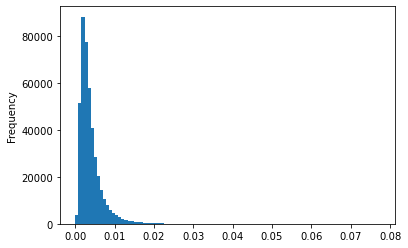

In [54]:
bins = np.linspace(0, df_train.target.max() * 1.1, 100)
df_train['target'].plot(kind='hist', bins=bins)

<AxesSubplot:ylabel='Frequency'>

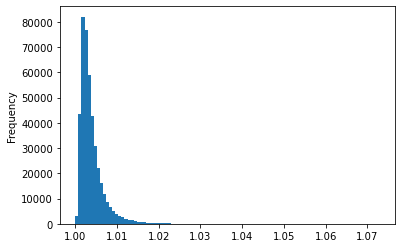

In [67]:
df_train['target_exp'] = np.exp(df_train.target)
bins = np.linspace(1.0, df_train['target_exp'].max() * 1.0001, 100)
df_train['target_exp'].plot(kind='hist', bins=bins)

<AxesSubplot:>

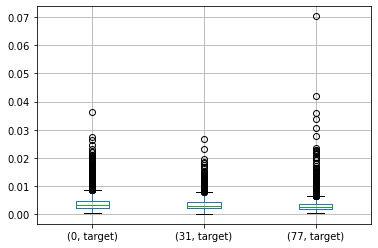

In [23]:
stock_ids = set([0, 77, 31])
dfx = df_train.query('stock_id in @stock_ids')
dfx.groupby('stock_id').boxplot(column='target', subplots=False)

## Get book data

In [24]:
stock_id = 0
time_id = 5

stock_id = 80
time_id = 20498

#stock_id = 40
#time_id = 10017

stock_id = 81
time_id = 14982


# high target
#stock_id = 77
#time_id = 24600
stock_id = 59
time_id = 23823
#stocki_id = 18
#time_id = 2956

# low target
stock_id = 31
#time_id = 8534
time_id = 27174

filename = 'book_train.parquet'
assert isinstance(stock_id, int)
df_book_train_stock_X = pd.read_parquet(
    os.path.join(ROOT, f"{filename}/stock_id={stock_id}")
)
df_book_train_stock_X["stock_id"] = stock_id
df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
display(df_book_train_stock_X.shape)
df_book_train_stock_X.reset_index().time_id.unique()

(1834156, 9)

array([    5,    11,    16, ..., 32758, 32763, 32767])

In [25]:
df_book_train_stock_X.head()

seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
stock_id time_id                                                          
31       5                        0    0.999604    1.000396    0.998813   
         5                        1    0.999604    1.000396    0.998813   
         5                        2    0.998021    0.998813    0.997230   
         5                        3    0.998021    0.998813    0.997230   
         5                        4    0.998021    0.998813    0.997230   

                  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  
stock_id time_id                                                          
31       5          1.001187      10603      10762      21200      12244  
         5          1.001187      10603      11062      21200      12244  
         5          0.999604       9415      15762      12343      23300  
         5          0.999604      10216      14862      11643      23300  
         5          0.999604       2216      14862      12743      23321

In [48]:
df_sub = df_book_train_stock_X.query('time_id == @time_id').set_index('seconds_in_bucket').copy()
df_sub['ask_bid_price1_diff'] = df_sub['ask_price1'] - df_sub['bid_price1'] 
df_sub

,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,ask_bid_price1_diff
seconds_in_bucket,,,,,,,,,
0,0.999189,1.000811,0.997567,1.002433,95057,43221,88733,37416,0.001622
1,0.999189,1.000811,0.997567,1.002433,95057,42921,88933,37416,0.001622
2,0.999189,1.000811,0.997567,1.002433,95057,37521,88933,37416,0.001622
3,0.999189,1.000811,0.997567,1.002433,92917,19181,89033,37216,0.001622
5,0.999189,1.000811,0.997567,1.002433,92917,23481,89033,37216,0.001622
...,...,...,...,...,...,...,...,...,...
591,1.000811,1.002433,0.999189,1.004055,91511,67046,96623,108334,0.001622
592,1.000811,1.002433,0.999189,1.004055,91511,67146,96623,108334,0.001622
594,1.000811,1.002433,0.999189,1.004055,91511,67146,96223,108334,0.001622


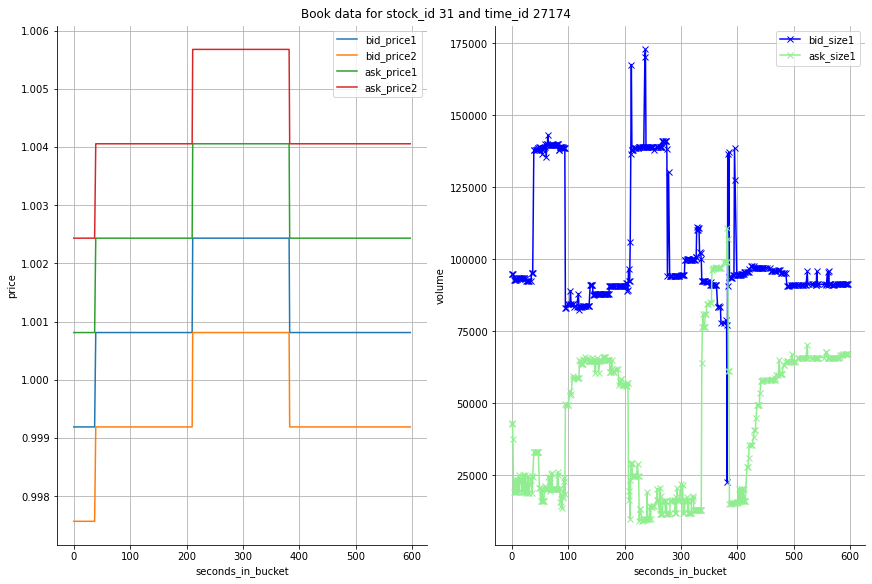

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8), constrained_layout=True)
ax = axs[0]
df_sub[['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2']].plot(ax=ax)
set_common_mpl_styles(ax, ylabel='price', grid_axis='both')
ax=axs[1]
# TODO figure out colors!
# only show bid/ask 1 as they're quite spikey and the plot gets confused
df_sub[['bid_size1', 'ask_size1']].plot(ax=ax, marker='x', linestyle='-', color=['blue', 'lightgreen'])
set_common_mpl_styles(ax, ylabel='volume', grid_axis='both')
fig.suptitle(f'Book data for stock_id {stock_id} and time_id {time_id}');

In [28]:
df_sub.bid_size1.value_counts().head(10)

138898    15
87918     15
90655     13
99952     11
93417     10
94394     10
139836     9
138995     9
91311      9
83728      8
Name: bid_size1, dtype: int64

In [29]:
df_sub.ask_size1.value_counts().head(10)

65942    17
11992     9
20195     8
19181     8
16095     8
13080     8
20295     8
16392     8
16292     7
9892      7
Name: ask_size1, dtype: int64

## Trade data

In [30]:
filename = 'trade_train.parquet'
assert isinstance(stock_id, int)
df_trade_train_stock_X = pd.read_parquet(
    os.path.join(ROOT, f"{filename}/stock_id={stock_id}")
)
df_trade_train_stock_X["stock_id"] = stock_id
df_trade_train_stock_X = df_trade_train_stock_X.set_index(['stock_id', 'time_id'])
display(df_trade_train_stock_X.shape)
df_trade_train_stock_X.head()

(129583, 4)

seconds_in_bucket     price   size  order_count
stock_id time_id                                                 
31       5                        2  0.998749  38184           60
         5                        3  0.998021    400            2
         5                       25  0.998813  10419           16
         5                       29  0.998813   3200            2
         5                       34  0.999604   5821           10

In [31]:
df_trade_sub = df_trade_train_stock_X.query('time_id == @time_id').set_index('seconds_in_bucket').copy()
display(df_trade_sub.shape)
df_trade_sub

(12, 3)

,price,size,order_count
seconds_in_bucket,,,
3,1.000811,19140,16
39,1.000811,14955,42
40,1.002433,17,2
47,1.002433,1,1
86,1.002433,100,2
87,1.002433,100,1
210,1.002433,11100,27
212,1.004055,39,1
290,1.004055,200,3


In [50]:
# often but not always a gap in book data around the trade point time
trade_point = 3
df_sub.query('seconds_in_bucket > (@trade_point-5) and seconds_in_bucket < (@trade_point+5)')

,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,ask_bid_price1_diff
seconds_in_bucket,,,,,,,,,
0,0.999189,1.000811,0.997567,1.002433,95057,43221,88733,37416,0.001622
1,0.999189,1.000811,0.997567,1.002433,95057,42921,88933,37416,0.001622
2,0.999189,1.000811,0.997567,1.002433,95057,37521,88933,37416,0.001622
3,0.999189,1.000811,0.997567,1.002433,92917,19181,89033,37216,0.001622
5,0.999189,1.000811,0.997567,1.002433,92917,23481,89033,37216,0.001622
6,0.999189,1.000811,0.997567,1.002433,93017,19181,89133,37216,0.001622
7,0.999189,1.000811,0.997567,1.002433,93017,22981,89133,37216,0.001622


In [32]:
df_trade_sub = df_trade_sub.reindex(index=np.arange(0, 600))
df_trade_sub['size'] = df_trade_sub['size'].fillna(0)
df_trade_sub['order_count'] = df_trade_sub['order_count'].fillna(0).astype(int)

In [33]:
df_trade_sub.head()

,price,size,order_count
seconds_in_bucket,,,
0,NaN,0.0,0
1,NaN,0.0,0
2,NaN,0.0,0
3,1.000811,19140.0,16
4,NaN,0.0,0


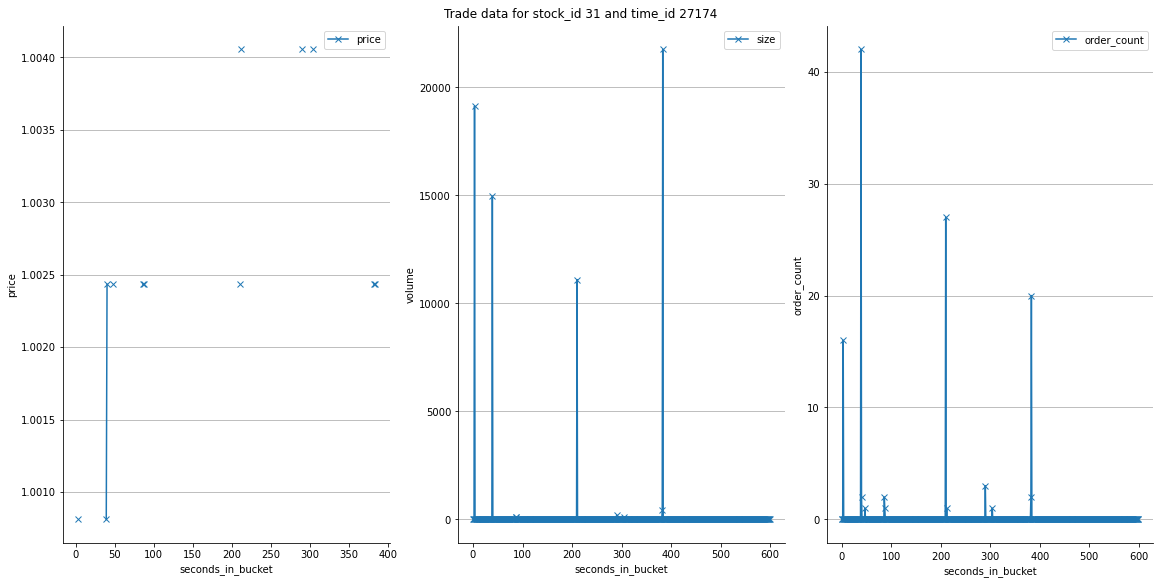

In [34]:
fig, axs = plt.subplots(ncols=3, figsize=(16,8), constrained_layout=True)
ax = axs[0]
df_trade_sub[['price']].plot(ax=ax, marker='x')
set_common_mpl_styles(ax, ylabel='price')
ax=axs[1]
# only show bid/ask 1 as they're quite spikey and the plot gets confused
df_trade_sub[['size']].plot(ax=ax, marker='x', linestyle='-')
set_common_mpl_styles(ax, ylabel='volume')
ax = axs[2]
df_trade_sub[['order_count']].plot(ax=ax, marker='x')
set_common_mpl_styles(ax, ylabel='order_count')

# DIAGNOSE https://matplotlib.org/stable/gallery/ticks_and_spines/tick-formatters.html
# I want scalar formatting
from matplotlib import ticker
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
fig.suptitle(f'Trade data for stock_id {stock_id} and time_id {time_id}');

# Train data